In [ ]:
import csv
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from random import shuffle
from sklearn.model_selection import train_test_split

In [2]:
import tensorflow as tf

In [3]:
DATA_PATH = "data/driving_log.csv"
DATA_IMGS = "data/"
BATCH_SIZE = 64
EPOCH = 1

In [4]:
class ProcessData() :
    """Classe pour traiter la dataset"""
    def __init__(self, data_path, data_imgs):
        """Constructeur de la classe qui permet d'initialiser les différents variables"""
        self.data_path = data_path
        self.data_imgs = data_imgs
        
    def index_data(self):
        """Fonction qui scinde les index de la dataset : set de train et set de validation"""
        with open(self.data_path, "r") as file :
            content = [line for line in csv.reader(file)]
        random_index = np.array(range(len(content)))
        train_index, valid_index = train_test_split(random_index, test_size=0.15)
        return content, train_index, valid_index
    
    def get_data(self, log_content, list_index, batch_size) :
        """Fonction qui fournit la batch à au model d'entraitement"""
        images, rotations = [], []
        for index in list_index :
            # Correction des angles
            angle_correction = [0., 0.25, -.25]
            # Selection randomiser d'une image
            i = random.choice([0,1,2])
            img = cv2.imread(os.path.join(self.data_imgs, log_content[index][i]).replace(" ", ""))
            if img is None: continue
            # Conversion de l'image
            img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            # Récupération de la rotation associé à l'image
            rotation = float(log_content[index][3])
            # Correction de l'angle
            rotation = rotation + angle_correction[i]
            if random.random() > 0.5 :
                img = cv2.flip(img,1)
                rotation = rotation * -1
            # Ajout dans les tableaux images et rotations
            images.append(img)
            rotations.append(rotation)
            if len(images) >= batch_size :
                yield np.array(images), np.array(rotations)
                images, rotations = [], [] 

In [5]:
data_process = ProcessData(DATA_PATH,DATA_IMGS)
content, train_index, valid_index = data_process.index_data()

0.25


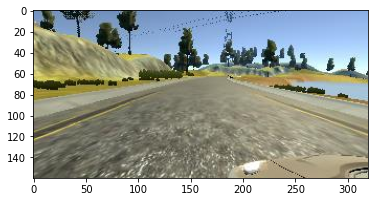

In [6]:
images, rotation = next(data_process.get_data(content, train_index, BATCH_SIZE))
plt.imshow(images[20])
print(rotation[20])

In [13]:
class CustomModel(tf.keras.Model):
    """Création d'un réseau de neurone"""
    def __init__(self):
        #initialisation de la classe parente
        super(CustomModel, self).__init__()
        # Définition des layers du model
        self.first_layer = tf.keras.layers.Lambda(lambda img : (tf.cast(img, tf.float32) / 127.5) - 1., input_shape = (160, 320, 3)) # Normalisation des images
        self.cropping_layer = tf.keras.layers.Cropping2D(cropping=((70, 25), (0, 0)), input_shape = (160, 320, 3)) # Réduction du champ de vision sur les images d'entrée
        self.first_conv_layer = tf.keras.layers.Conv2D(8, 9, strides=(4, 4), padding="same", activation="elu") # Première convolution
        self.second_conv_layer = tf.keras.layers.Conv2D(16, 5, strides=(2, 2), padding="same", activation="elu") # Seconde convolution
        self.third_conv_layer = tf.keras.layers.Conv2D(32, 4, strides=(1, 1), padding="same", activation="elu") # Troisième convolution
        self.flatten_layer = tf.keras.layers.Flatten() # Couche de Flatten
        self.first_dropout_layer = tf.keras.layers.Dropout(.6)
        self.dense_layer = tf.keras.layers.Dense(1024, activation="elu")
        self.second_dropout_layer = tf.keras.layers.Dropout(.3)
        self.output_layer = tf.keras.layers.Dense(1, activation="elu")
    def call(self, img):
        #Fonction de prédiction
        input_x =  self.first_layer(img)
        cropping_x = self.cropping_layer(input_x)
        first_conv_x = self.first_conv_layer(cropping_x)
        second_conv_x = self.second_conv_layer(first_conv_x)
        third_conv_x = self.third_conv_layer(second_conv_x)
        flatten_x = self.flatten_layer(third_conv_x)
        first_dropout_x = self.first_dropout_layer(flatten_x)
        dense_x = self.dense_layer(first_dropout_x)
        second_dropout_x = self.second_dropout_layer(dense_x)
        output_x = self.output_layer(second_dropout_x)
        return output_x
        

In [14]:
model = CustomModel() # Création d'un model
model.compile(loss="mse", optimizer="adam")
model.fit_generator(
    generator=data_process.get_data(content, train_index, BATCH_SIZE),
    steps_per_epoch=len(train_index) / BATCH_SIZE,
    validation_data=data_process.get_data(content, valid_index, BATCH_SIZE),
    validation_steps=len(valid_index) / BATCH_SIZE,
    epochs=EPOCH)

106/106 [============================>.] - 563s 5s/step - loss: 1.0977 - val_loss: 1.0593


In [16]:
model.save_weights("model.h5")